In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from _utils import get_data_dir

DATA_DIR = get_data_dir()


In [3]:
# model master
from pyexpat import model
import pandas as pd
from pathlib import Path
from _utils import get_data_dir

ROOT = get_data_dir()
conds = ["50_50", "80_20", "100_0"]
dfs = []

def load_decisions(path, cond, model):
    df = pd.read_csv(path)
    df["stimID"] = df["image_id"]
    df["condition"] = cond
    df["participantID"] = model
    df["response"] = (
        df["GPT_response"].astype(str).str.strip().str.lower()
        .replace({"true": "present", "false": "absent"})
    )
    df["decision"] = df["response"].map({"present": 1, "absent": 0})
    return df[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]]

def df_to_pdf(df, filename):
    df = df.round(3)
    fig, ax = plt.subplots(figsize=(12, len(df)*0.4 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')

def parse_gemini(resp):
    a1, a2, dec = [p.strip() for p in str(resp).split(",")]
    return float(a1), float(a2), dec.lower()

for cond in conds:
    base = ROOT / cond

    # all decision models — now using decisions_fixed
    decisions_dir = base / "decisions_fixed"
    if not decisions_dir.exists():
        print(f"[WARN] {decisions_dir} not found, falling back to 'decisions' for {cond}")
        decisions_dir = base / "decisions"

    for f in decisions_dir.glob("*.csv"):
        dfs.append(load_decisions(f, cond, f.stem))

    # gemini angle-estimation model (unchanged)
    g = pd.read_csv(base / "angle_estimations" / "gemini-2.5-pro.csv")
    g[["est1", "est2", "response"]] = pd.DataFrame(
        g["GPT_response"].apply(parse_gemini).tolist(), index=g.index
    )
    g["stimID"] = g["image_id"]
    g["condition"] = cond
    g["participantID"] = "gemini-2.5-pro"
    g["decision"] = g["response"].map({"present": 1, "absent": 0})
    dfs.append(g[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]])

model_master = pd.concat(dfs, ignore_index=True)
display(model_master)


,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
0,100,50_50,1,2,14.314827,1.921956,False,True,present,0responses_claude-3-5-haiku-20241022,1
1,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_claude-3-5-haiku-20241022,0
2,245,50_50,1,1,14.314827,6.508956,True,True,present,0responses_claude-3-5-haiku-20241022,1
3,72,50_50,2,2,8.775056,15.054317,True,True,absent,0responses_claude-3-5-haiku-20241022,0
4,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_claude-3-5-haiku-20241022,0
...,...,...,...,...,...,...,...,...,...,...,...
38995,698,100_0,1,1,11.159944,6.508956,True,False,present,gemini-2.5-pro,1
38996,910,100_0,1,2,9.651833,4.986334,False,False,absent,gemini-2.5-pro,0
38997,880,100_0,2,2,4.222230,8.775056,True,False,absent,gemini-2.5-pro,0
38998,53,100_0,2,2,4.986334,11.908300,True,False,present,gemini-2.5-pro,1


In [4]:
#All Models Metrics Table

df = model_master.copy()

def compute_sdt(df):
    hits = ((df["TP"]==1) & (df["decision"]==1)).mean()
    fas  = ((df["TP"]==0) & (df["decision"]==1)).mean()

    # Add tiny epsilon to avoid inf in z-scores
    eps = 1e-6
    dprime = norm.ppf(min(max(hits, eps), 1-eps)) - norm.ppf(min(max(fas, eps), 1-eps))
    crit   = -0.5*( norm.ppf(min(max(hits, eps), 1-eps)) + 
                    norm.ppf(min(max( fas, eps), 1-eps)) )
    return hits, fas, dprime, crit

rows = []
for (model, cond), g in df.groupby(["participantID","condition"]):
    acc = (g["decision"] == g["TP"]).mean()
    hits, fas, dp, c = compute_sdt(g)
    rows.append({
        "participantID": model,
        "condition": cond,
        "n_trials": len(g),
        "accuracy": acc,
        "hit_rate": hits,
        "fa_rate": fas,
        "dprime": dp,
        "criterion": c
    })

AMM = pd.DataFrame(rows)
AMM

,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,0responses_claude-3-5-haiku-20241022,100_0,1000,0.716,0.297,0.081,0.865328,0.965713
1,0responses_claude-3-5-haiku-20241022,50_50,1000,0.594,0.245,0.151,0.341845,0.861231
2,0responses_claude-3-5-haiku-20241022,80_20,1000,0.720,0.291,0.071,0.917918,1.009425
3,0responses_claude-3-7-sonnet-20250219,100_0,1000,0.850,0.418,0.068,1.283841,0.848933
4,0responses_claude-3-7-sonnet-20250219,50_50,1000,0.820,0.372,0.052,1.299202,0.976162
5,0responses_claude-3-7-sonnet-20250219,80_20,1000,0.847,0.417,0.070,1.266217,0.842683
6,0responses_claude-opus-4-20250514,100_0,1000,0.801,0.343,0.042,1.323645,1.066112
7,0responses_claude-opus-4-20250514,50_50,1000,0.737,0.299,0.062,1.010920,1.032739
8,0responses_claude-opus-4-20250514,80_20,1000,0.737,0.310,0.073,0.957956,0.974828
9,0responses_claude-sonnet-4-20250514,100_0,1000,0.766,0.471,0.205,0.751137,0.448325


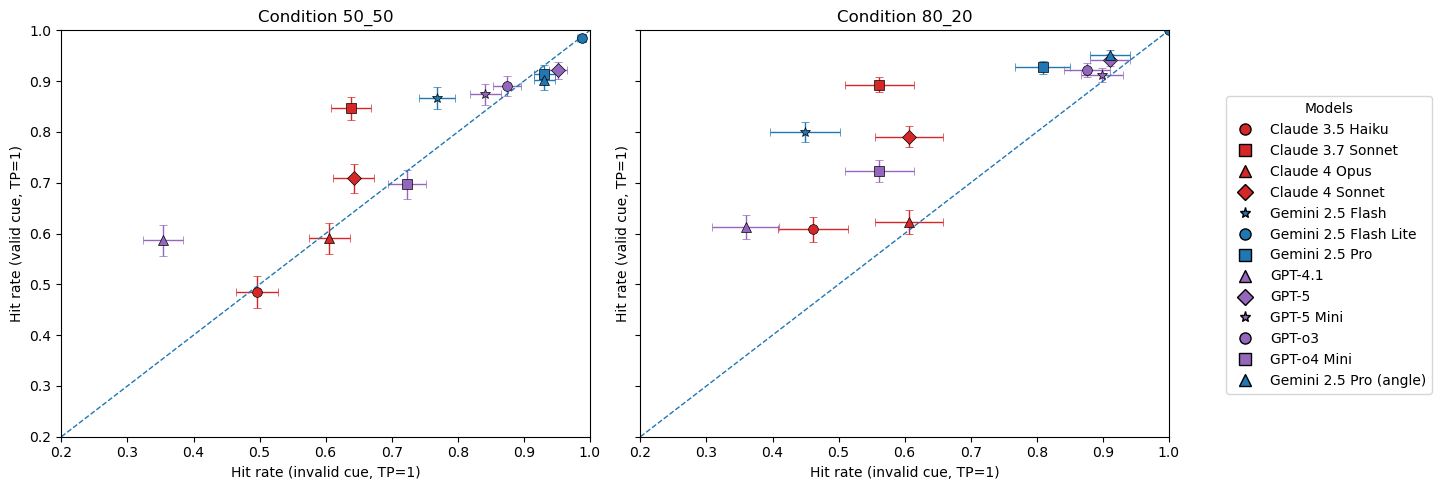

In [5]:
# Hit Rate Plot

# Pretty names
name_map = {
    "0responses_gemini-2.5-flash":                    "Gemini 2.5 Flash",
    "0responses_gemini-2.5-flash-lite-preview-06-17": "Gemini 2.5 Flash Lite",
    "0responses_gemini-2.5-pro":                      "Gemini 2.5 Pro",
    "gemini-2.5-pro":                                 "Gemini 2.5 Pro (angle)",

    "0responses_gpt-5-2025-08-07":                    "GPT-5",
    "0responses_gpt-5-mini-2025-08-07":               "GPT-5 Mini",
    "0responses_o3-2025-04-16":                       "GPT-o3",
    "0responses_o4-mini-2025-04-16":                  "GPT-o4 Mini",
    "0responses_gpt-4.1-2025-04-14":                  "GPT-4.1",

    "0responses_claude-3-5-haiku-20241022":           "Claude 3.5 Haiku",
    "0responses_claude-3-7-sonnet-20250219":          "Claude 3.7 Sonnet",
    "0responses_claude-opus-4-20250514":              "Claude 4 Opus",
    "0responses_claude-sonnet-4-20250514":            "Claude 4 Sonnet",
}

# Family mapping (1 = Gemini, 2 = GPT, 3 = Claude)
family_map = {
    "0responses_gemini-2.5-flash":                    "Gemini",  # 1
    "0responses_gemini-2.5-flash-lite-preview-06-17": "Gemini",  # 1
    "0responses_gemini-2.5-pro":                      "Gemini",  # 1
    "gemini-2.5-pro":                                 "Gemini",  # 1

    "0responses_gpt-5-2025-08-07":                    "GPT",     # 2
    "0responses_gpt-5-mini-2025-08-07":               "GPT",     # 2
    "0responses_o3-2025-04-16":                       "GPT",     # 2
    "0responses_o4-mini-2025-04-16":                  "GPT",     # 2
    "0responses_gpt-4.1-2025-04-14":                  "GPT",     # 2

    "0responses_claude-3-5-haiku-20241022":           "Claude",  # 3
    "0responses_claude-3-7-sonnet-20250219":          "Claude",  # 3
    "0responses_claude-opus-4-20250514":              "Claude",  # 3
    "0responses_claude-sonnet-4-20250514":            "Claude",  # 3
}

# Color per family
family_colors = {
    "Gemini": "#1f77b4",  # blue
    "GPT":    "#9467bd",  # purple
    "Claude": "#d62728",  # red
}

# Only use these four markers; cycle if more models
markers = ['o', 's', '^', 'D', '*']   # circle, square, triangle, diamond, star

# =========================
# 1. Compute HR + SE from TP=1 only (via hit/miss counts)
# =========================

df = model_master.copy()

# 1a. Restrict to target-present trials and define "hit" (decision == 1)
tp1 = (
    df[df["TP"] == 1]
    .assign(hit=lambda d: (d["decision"] == 1).astype(int))
)

# 1b. Get raw hit & trial counts per participant × condition × cue validity
counts = (
    tp1
    .groupby(["participantID", "condition", "valid_cue"], as_index=False)
    .agg(
        hits=("hit", "sum"),
        n_tp=("hit", "size")
    )
)

counts["misses"] = counts["n_tp"] - counts["hits"]

# 1c. Split to wide (valid vs invalid) for each participant × condition
valid = (
    counts[counts["valid_cue"] == 1]
    .rename(columns={
        "hits": "hits_valid",
        "misses": "misses_valid",
        "n_tp": "n_valid"
    })
    .drop(columns=["valid_cue"])
)

invalid = (
    counts[counts["valid_cue"] == 0]
    .rename(columns={
        "hits": "hits_invalid",
        "misses": "misses_invalid",
        "n_tp": "n_invalid"
    })
    .drop(columns=["valid_cue"])
)

hr = valid.merge(invalid, on=["participantID", "condition"], how="inner")

# 1d. Compute hit rates from counts
hr["hr_valid"] = hr["hits_valid"] / (hr["hits_valid"] + hr["misses_valid"])
hr["hr_invalid"] = hr["hits_invalid"] / (hr["hits_invalid"] + hr["misses_invalid"])

# 1e. Binomial SEs using actual trial counts
hr["se_valid"]   = np.sqrt(hr["hr_valid"]   * (1 - hr["hr_valid"])   / hr["n_valid"])
hr["se_invalid"] = np.sqrt(hr["hr_invalid"] * (1 - hr["hr_invalid"]) / hr["n_invalid"])

# Only plot 50_50 and 80_20 conditions
hr_plot = hr[hr["condition"].isin(["50_50", "80_20"])].copy()

# Pretty labels & families
hr_plot["model_label"] = hr_plot["participantID"].map(name_map).fillna(hr_plot["participantID"])
hr_plot["family"]      = hr_plot["participantID"].map(family_map).fillna("Other")

# =========================
# 2. Build style: color = family, marker = model
# =========================

model_ids = sorted(hr_plot["participantID"].unique())

model_style = {}
for i, mid in enumerate(model_ids):
    fam    = family_map.get(mid, "Other")
    color  = family_colors.get(fam, "gray")
    marker = markers[i % len(markers)]

    model_style[mid] = {
        "color": color,
        "marker": marker,
        "family": fam,
        "label": hr_plot.loc[hr_plot["participantID"] == mid, "model_label"].iloc[0]
    }

# =========================
# 3. Plot HR scatter with double-axis error bars
# =========================

conds = ["50_50", "80_20"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, cond in zip(axes, conds):
    sub = hr_plot[hr_plot["condition"] == cond]

    for mid in model_ids:
        msub = sub[sub["participantID"] == mid]
        if msub.empty:
            continue

        style = model_style[mid]

        x    = msub["hr_invalid"].values
        y    = msub["hr_valid"].values
        xerr = msub["se_invalid"].values
        yerr = msub["se_valid"].values

        ax.errorbar(
            x, y,
            xerr=xerr,
            yerr=yerr,
            fmt=style["marker"],
            markersize=7,
            linestyle="none",
            color=style["color"],
            ecolor=style["color"],
            elinewidth=1,
            capsize=3,
            markeredgecolor="black",
            markeredgewidth=0.5,
        )

    # Diagonal = no cueing benefit
    ax.plot([0.2, 1.0], [0.2, 1.0], linestyle="--", linewidth=1)

    ax.set_title(f"Condition {cond}")
    ax.set_xlabel("Hit rate (invalid cue, TP=1)")
    ax.set_ylabel("Hit rate (valid cue, TP=1)")
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

# =========================
# 4. Legend: models only (color encodes family implicitly)
# =========================

legend_handles = []
legend_labels = []

for mid in model_ids:
    props = model_style[mid]
    handle = plt.Line2D(
        [], [],
        color=props["color"],
        marker=props["marker"],
        markersize=8,
        linestyle="none",
        markeredgecolor="black"
    )
    legend_handles.append(handle)
    legend_labels.append(props["label"])

fig.legend(
    legend_handles,
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    title="Models"
)

plt.tight_layout()
plt.show()

output_path = r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs\model_hit_rates.pdf"

fig.savefig(output_path, dpi=300, bbox_inches="tight")

In [6]:
#Top 8 Models by Simple Hit Rate and Cue Advantage
df = model_master.copy()

hits = (
    df[df["TP"] == 1]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)


hr = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)


hr = hr[hr["condition"].isin(["50_50", "80_20"])]


hr["delta_hr"] = hr["hr_valid"] - hr["hr_invalid"]


model_hr = (
    hr.groupby("participantID", as_index=False)
      .agg(mean_hr_valid=("hr_valid", "mean"),
           mean_delta_hr=("delta_hr", "mean"))
)


model_hr["score"] = model_hr["mean_hr_valid"] + model_hr["mean_delta_hr"]


best8_simple = model_hr.sort_values("score", ascending=False).head(8)
best8_names = best8_simple["participantID"].tolist()

BMM = model_master[model_master["participantID"].isin(best8_names)].copy()


display(BMM.head())

,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
1000,100,50_50,1,2,14.314827,1.921956,False,True,present,0responses_claude-3-7-sonnet-20250219,1
1001,845,50_50,1,2,15.054317,4.222230,False,True,present,0responses_claude-3-7-sonnet-20250219,1
1002,245,50_50,1,1,14.314827,6.508956,True,True,present,0responses_claude-3-7-sonnet-20250219,1
1003,72,50_50,2,2,8.775056,15.054317,True,True,present,0responses_claude-3-7-sonnet-20250219,1
1004,469,50_50,2,2,4.222230,19.885165,True,True,present,0responses_claude-3-7-sonnet-20250219,1


C:\Users\AdamR\AppData\Local\Temp\ipykernel_19560\2536088714.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sdt_metrics_group)


,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion,who
0,majority,100_0,1000,0.890,0.952,0.172,2.610854,-0.359136,NaN
1,maj_pos_exception,100_0,1000,0.868,0.974,0.238,2.655885,-0.615191,NaN
2,maj_neg_exception,100_0,1000,0.893,0.948,0.162,2.612035,-0.319746,NaN
3,majority,50_50,1000,0.841,0.922,0.240,2.124956,-0.356176,NaN
4,maj_pos_exception,50_50,1000,0.846,0.950,0.258,2.294377,-0.497665,NaN
5,maj_neg_exception,50_50,1000,0.860,0.888,0.168,2.178059,-0.126931,NaN
6,majority,80_20,1000,0.847,0.934,0.240,2.212564,-0.399980,NaN
7,maj_pos_exception,80_20,1000,0.826,0.958,0.306,2.235155,-0.610357,NaN
8,maj_neg_exception,80_20,1000,0.866,0.920,0.188,2.290362,-0.259891,NaN
9,best_individual,100_0,8000,0.890,0.928,0.148,2.506106,-0.208003,0responses_gemini-2.5-pro


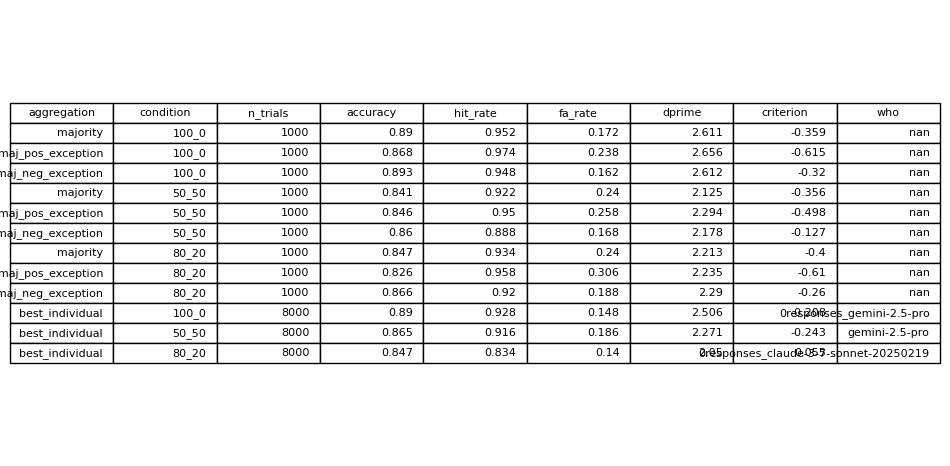

In [7]:
#model metrics and aggregation

df = BMM.copy()

# Ensure decisions are numeric 0/1
df["decision"] = df["decision"].astype(int)

# -----------------------------
# 1. Per-model SDT metrics
# -----------------------------
def sdt_metrics_group(g):
    n = len(g)
    tp1 = g["TP"] == 1
    tp0 = ~tp1
    resp1 = g["decision"] == 1

    hits = (resp1 & tp1).sum()
    fas  = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))

    return pd.Series({
        "n_trials": n,
        "accuracy": accuracy,
        "hit_rate": hit_rate,
        "fa_rate": fa_rate,
        "dprime": dprime,
        "criterion": criterion,
    })

model_participant_metrics = (
    df.groupby(["participantID", "condition"])
      .apply(sdt_metrics_group)
      .reset_index()
)

# -----------------------------
# 2. Aggregation-level metrics
# -----------------------------
def sdt_from_binary(decisions, TPs):
    decisions = np.asarray(decisions).astype(int)
    TPs = np.asarray(TPs).astype(int)
    n = len(decisions)

    tp1 = TPs == 1
    tp0 = ~tp1
    resp1 = decisions == 1

    hits = (resp1 & tp1).sum()
    fas  = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps = 1e-5
    hit_rate = np.clip(hit_rate, eps, 1 - eps)
    fa_rate  = np.clip(fa_rate,  eps, 1 - eps)

    zH, zF = norm.ppf(hit_rate), norm.ppf(fa_rate)
    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return accuracy, hit_rate, fa_rate, dprime, c

rows = []

for cond, df_c in df.groupby("condition"):
    # decisions per stimID × model (numeric)
    dec_piv = df_c.pivot_table(
        index="stimID",
        columns="participantID",
        values="decision",
        aggfunc="mean"
    )

    # majority vote across models
    maj = (dec_piv.mean(axis=1) > 0.5).astype(int).values

    # Gemini decider: use gemini-2.5-pro's decision
    gem = (dec_piv["gemini-2.5-pro"] > 0.5).astype(int).values

    # TPs aligned to stimID order
    trials = df_c.drop_duplicates("stimID").set_index("stimID").loc[dec_piv.index]
    TPs = trials["TP"].astype(int).values

    # Gemini-based positive exception:
    # if Gemini says present -> 1, else majority
    pos_ex = np.where(gem == 1, 1, maj)

    # Gemini-based negative exception:
    # if Gemini says absent -> 0, else majority
    neg_ex = np.where(gem == 0, 0, maj)

    for name, decisions in [
        ("majority", maj),
        ("maj_pos_exception", pos_ex),
        ("maj_neg_exception", neg_ex),
    ]:
        acc, H, F, dp, c = sdt_from_binary(decisions, TPs)
        rows.append({
            "aggregation": name,
            "condition": cond,
            "n_trials": len(decisions),
            "accuracy": acc,
            "hit_rate": H,
            "fa_rate": F,
            "dprime": dp,
            "criterion": c,
        })

# -----------------------------
# 3. Best individual model per condition
# -----------------------------
best_rows = []
for cond, df_c in df.groupby("condition"):
    stats = []
    for pid, dfg in df_c.groupby("participantID"):
        acc, hit, fa, dp, c = sdt_from_binary(dfg["decision"], dfg["TP"])
        stats.append((pid, acc, hit, fa, dp, c))

    pid, acc, hit, fa, dp, c = max(stats, key=lambda x: x[1])
    best_rows.append({
        "aggregation": "best_individual",
        "condition": cond,
        "n_trials": len(df_c),
        "accuracy": acc,
        "hit_rate": hit,
        "fa_rate": fa,
        "dprime": dp,
        "criterion": c,
        "who": pid
    })


# -----------------------------
# 5. Final: model_agg table
# -----------------------------
model_agg = pd.DataFrame(rows)
model_agg = pd.concat([model_agg, pd.DataFrame(best_rows)], ignore_index=True)

display(model_agg)
df_to_pdf(model_agg, "outputs/model_agg_table.pdf")

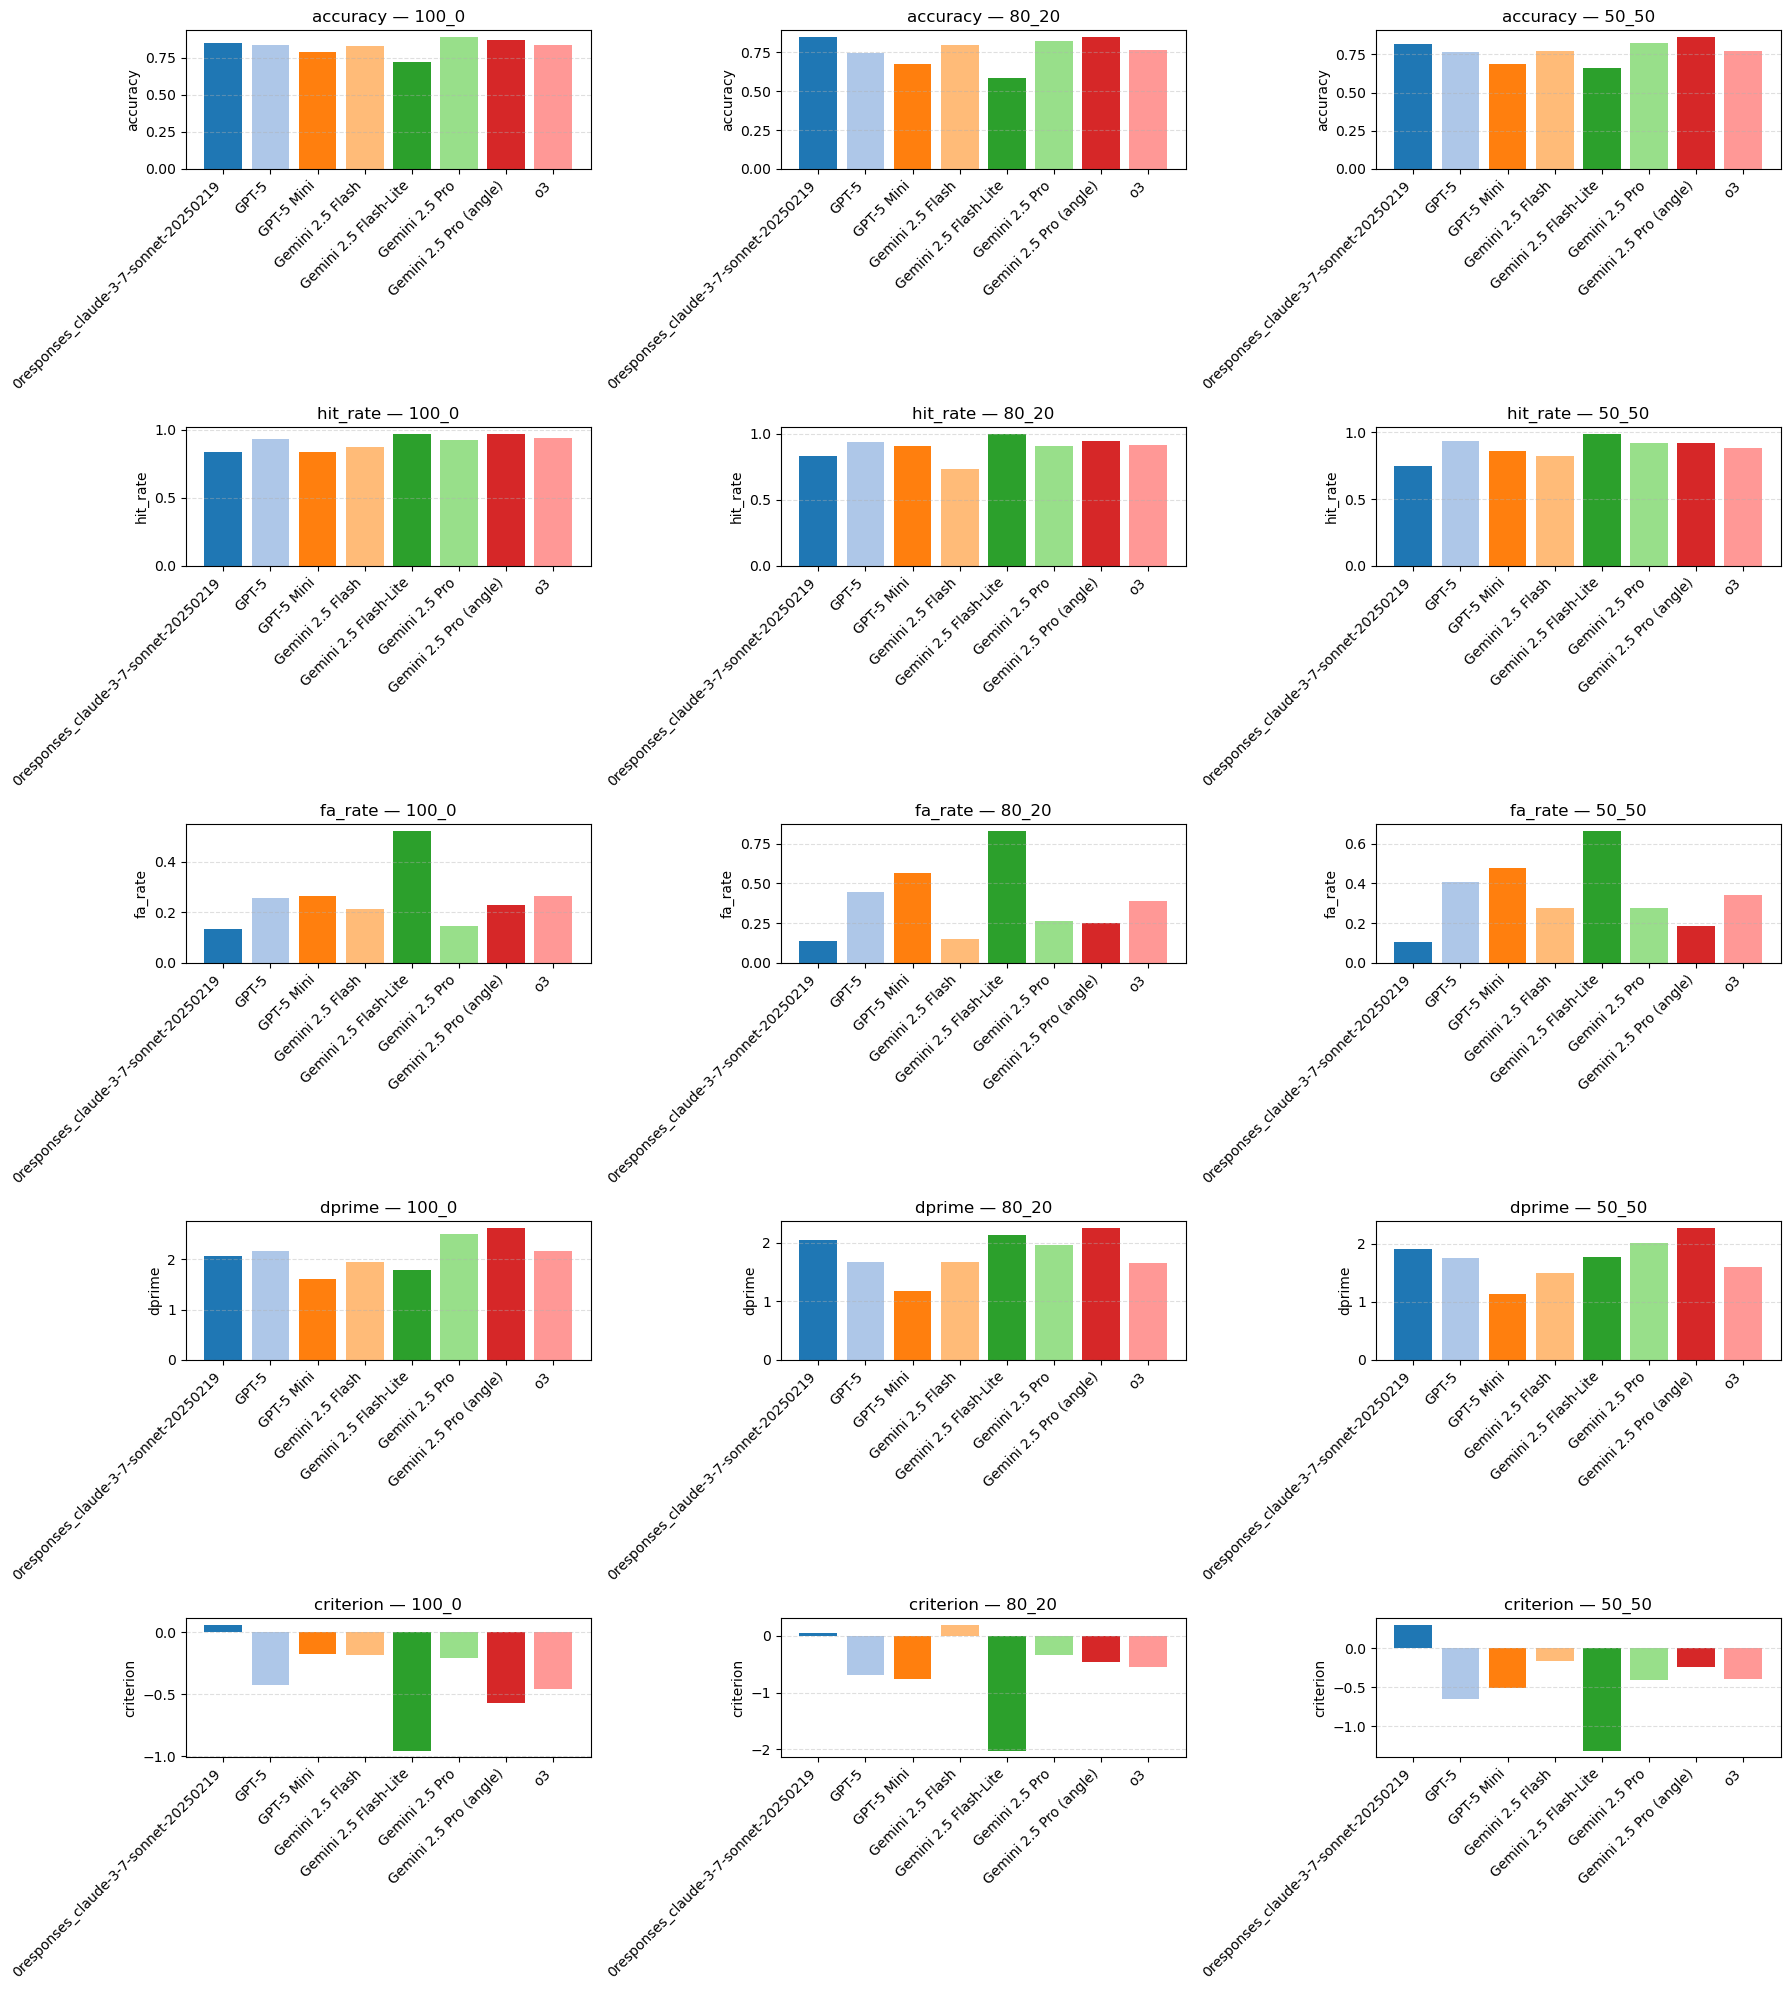

In [8]:
#plotting individual models
mpm = model_participant_metrics.copy()

name_map = {
    "0responses_gemini-2.5-flash": "Gemini 2.5 Flash",
    "0responses_gemini-2.5-flash-lite-preview-06-17": "Gemini 2.5 Flash-Lite",
    "0responses_gemini-2.5-pro": "Gemini 2.5 Pro",
    "0responses_gpt-5-2025-08-07": "GPT-5",
    "0responses_gpt-5-mini-2025-08-07": "GPT-5 Mini",
    "0responses_o3-2025-04-16": "o3",
    "0responses_o4-mini-2025-04-16": "o4 Mini",
    "gemini-2.5-pro": "Gemini 2.5 Pro (angle)",
}

mpm["model_label"] = mpm["participantID"].map(name_map).fillna(mpm["participantID"])

# --------------------------
# Define metrics & conditions
# --------------------------
metrics = ["accuracy", "hit_rate", "fa_rate", "dprime", "criterion"]
conds = sorted(mpm["condition"].unique())

models_sorted = sorted(mpm["model_label"].unique())

# Assign consistent colors
colors = {m: plt.cm.tab20(i % 20) for i, m in enumerate(models_sorted)}

conds = ["100_0", "80_20", "50_50"]

fig, axes = plt.subplots(
    len(metrics), len(conds),
    figsize=(6 * len(conds), 4 * len(metrics)),
    sharey=False
)

if len(conds) == 1:
    axes = np.array([axes]).reshape(len(metrics), 1)


for i, metric in enumerate(metrics):
    for j, cond in enumerate(conds):
        ax = axes[i, j]
        
        # Filter data for this condition
        sub = mpm[mpm["condition"] == cond].copy()
        
        # Reindex to FIXED model ordering (keeps ordering constant)
        sub = sub.set_index("model_label").reindex(models_sorted).reset_index()
        
        # x positions always same order
        x = np.arange(len(sub))
        
        # Plot bars
        ax.bar(
            x,
            sub[metric],
            color=[colors[m] for m in sub["model_label"]]
        )

        # Set ticks *then* labels (avoids warnings)
        ax.set_xticks(x)
        ax.set_xticklabels(sub["model_label"], rotation=45, ha="right")

        ax.set_title(f"{metric} — {cond}", fontsize=12)
        ax.set_ylabel(metric)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()


output_path = r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs\model_individual_plots.pdf"

with PdfPages(output_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")  # save this figure as 1 page

# Now show on screen
plt.show()

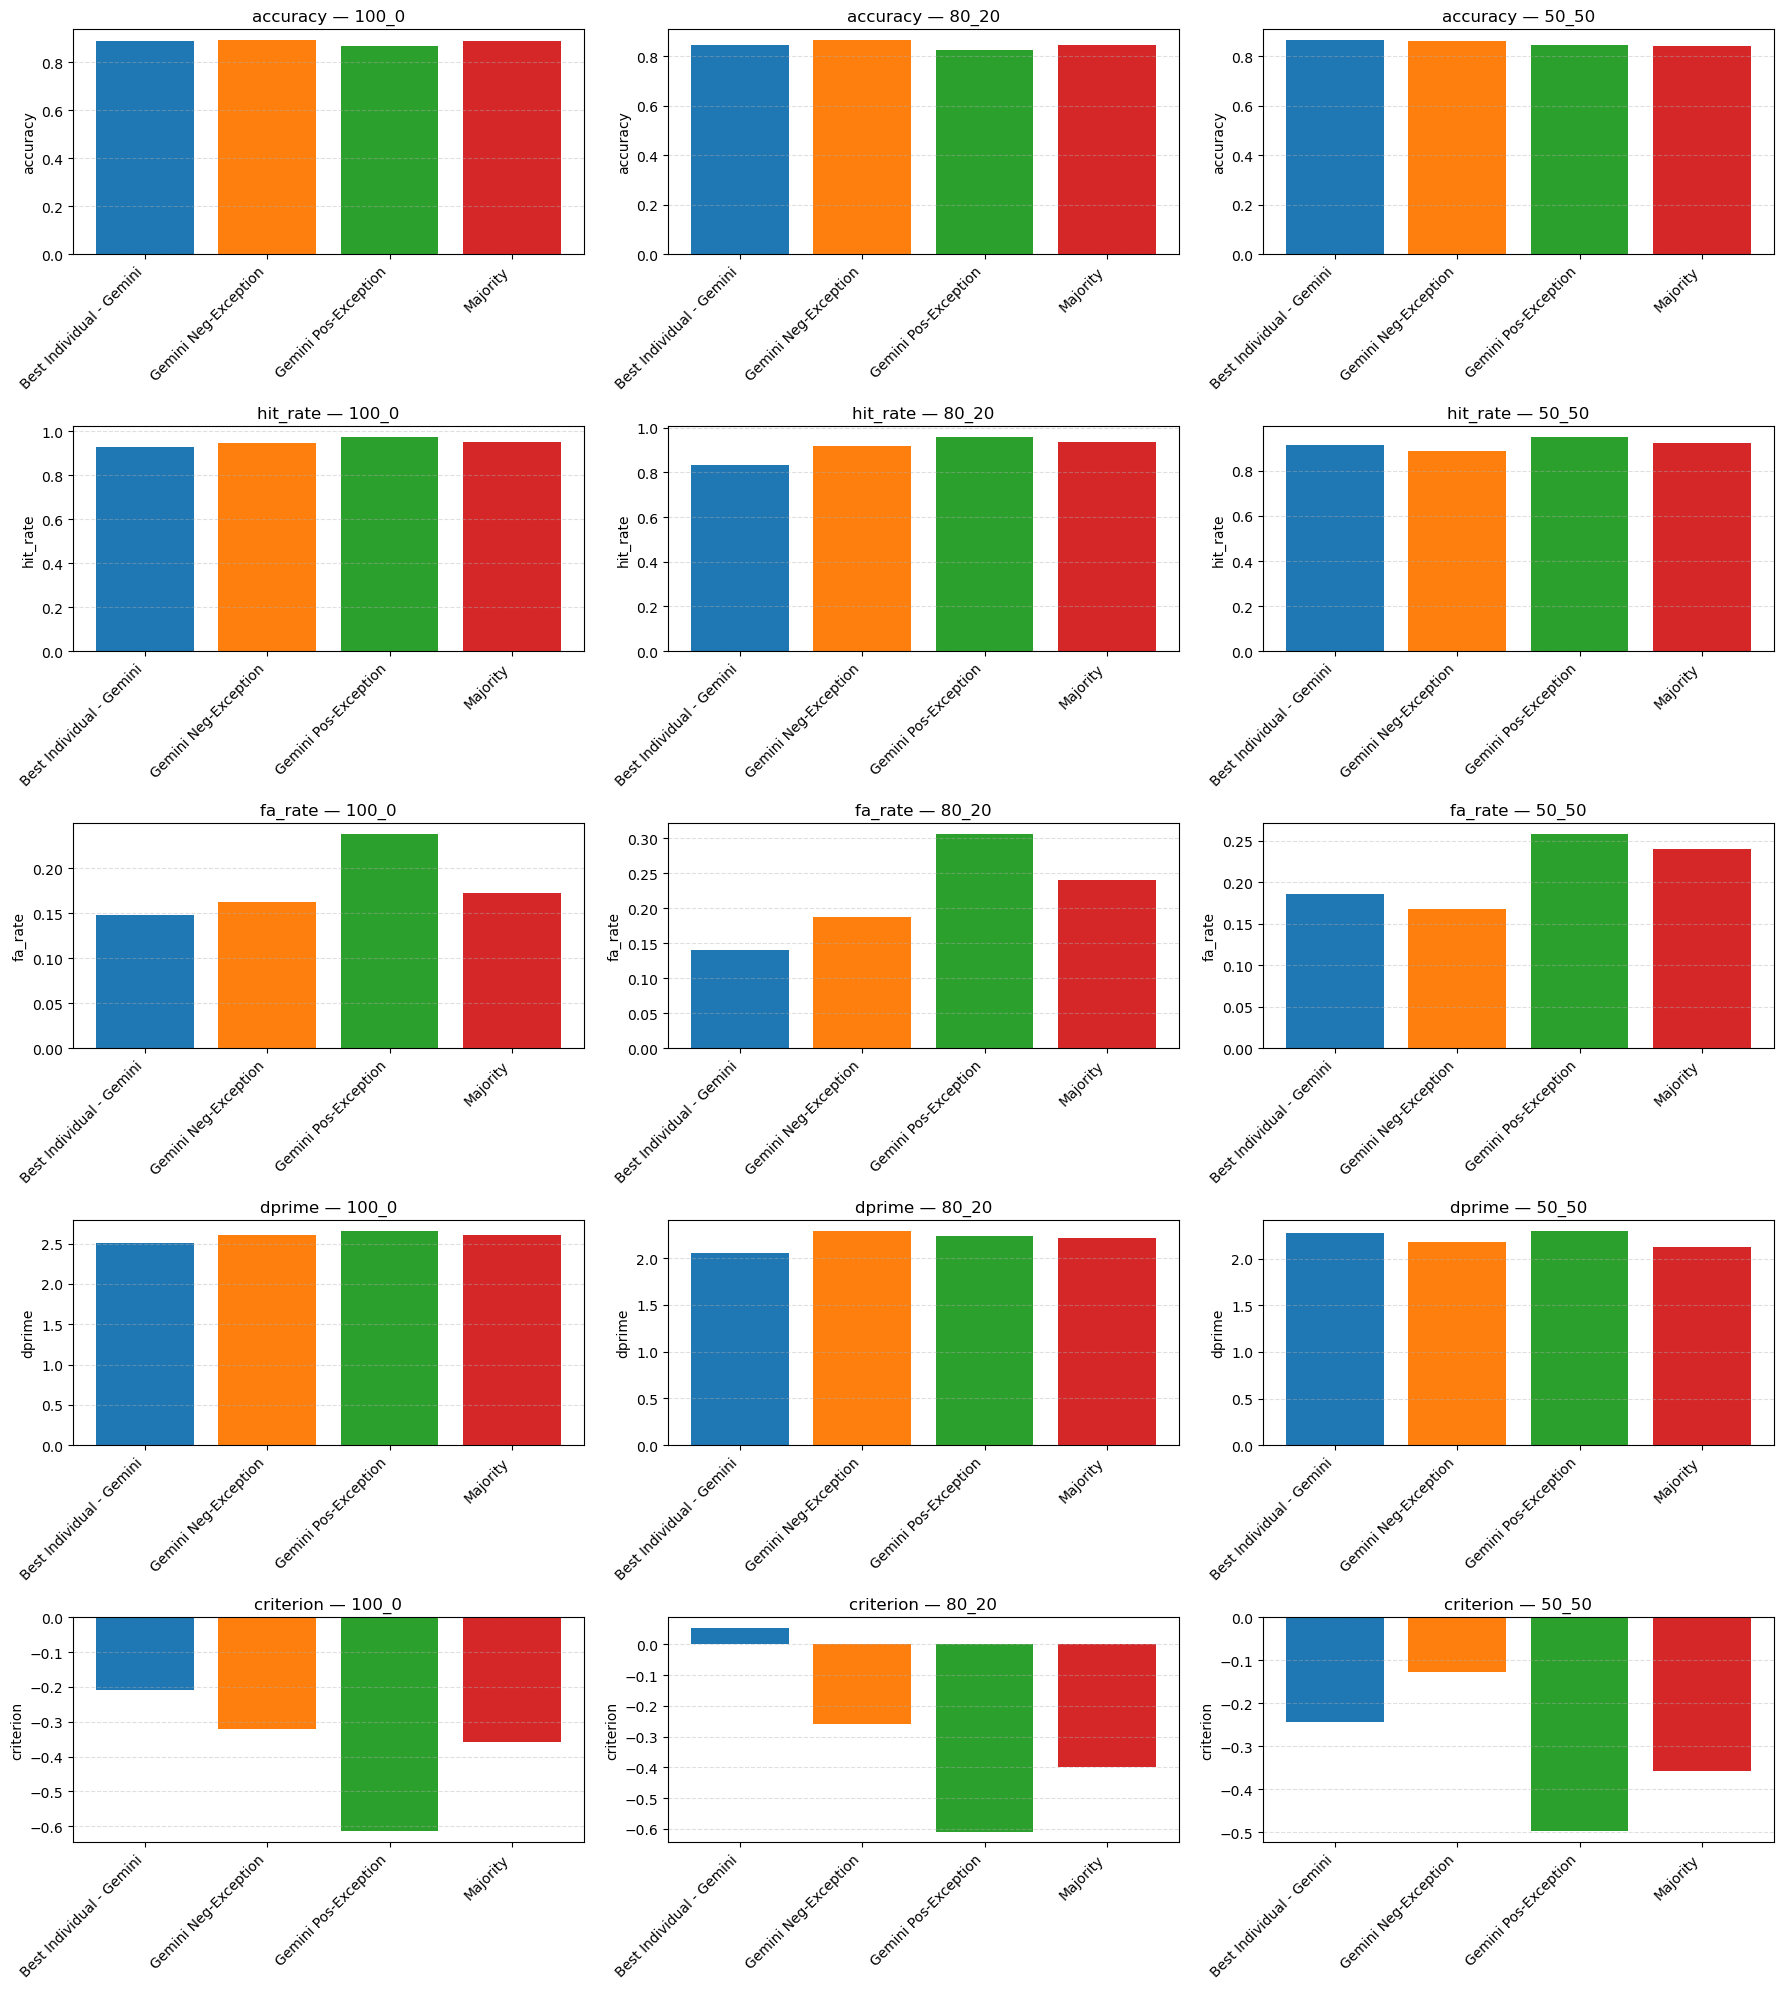

In [9]:
#Aggregation Plots
mag = model_agg.copy()


agg_name_map = {
    "majority": "Majority",
    "maj_pos_exception": "Gemini Pos-Exception",
    "maj_neg_exception": "Gemini Neg-Exception",
    "best_individual": "Best Individual - Gemini",
    "WLC": "WLC",
}
mag["agg_label"] = mag["aggregation"].map(agg_name_map).fillna(mag["aggregation"])

# --------------------------
# Metrics & fixed condition ordering
# --------------------------
metrics = ["accuracy", "hit_rate", "fa_rate", "dprime", "criterion"]
conds = ["100_0", "80_20", "50_50"]

# Fixed aggregation ordering
aggs_sorted = sorted(mag["agg_label"].unique())

# Consistent colors per aggregation
colors = {a: plt.cm.tab10(i % 10) for i, a in enumerate(aggs_sorted)}

# --------------------------
# Create subplot grid
# --------------------------
fig, axes = plt.subplots(
    len(metrics), len(conds),
    figsize=(6 * len(conds), 4 * len(metrics)),
    sharey=False
)

# Ensure axes is 2D
if len(conds) == 1:
    axes = np.array([axes]).reshape(len(metrics), 1)

# --------------------------
# Plotting loop
# --------------------------
for i, metric in enumerate(metrics):
    for j, cond in enumerate(conds):
        ax = axes[i, j]
        
        # Filter this condition
        sub = mag[mag["condition"] == cond].copy()
        
        # Align to fixed aggregation ordering
        sub = sub.set_index("agg_label").reindex(aggs_sorted).reset_index()
        
        x = np.arange(len(sub))
        
        ax.bar(
            x,
            sub[metric],
            color=[colors[a] for a in sub["agg_label"]]
        )

        ax.set_xticks(x)
        ax.set_xticklabels(sub["agg_label"], rotation=45, ha="right")

        ax.set_title(f"{metric} — {cond}", fontsize=12)
        ax.set_ylabel(metric)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

output_path = r"C:\Users\AdamR\Projects\Flexible-Wisdom\outputs\model_aggregation_plots.pdf"

with PdfPages(output_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")  # save this figure as 1 page

# Now show on screen
plt.show()
